In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import matplotlib.cm as cm
    
import sys 
sys.path.insert(0, '../src/')

from astropy.table import Table
import warnings; warnings.simplefilter('ignore')
import emcee
import corner
from multiprocess import Pool
import time

In [88]:
def cumulative(lgMs_1D):
    """

    Args:
        Ms (numpy): 1D mass array
        mass_bins (numpy): mass bins

    Returns:
        CSMF (numpy): counts in each bin
    """

    mass_bins = np.linspace(4,11,45)

    N = np.histogram(lgMs_1D, bins=mass_bins)[0]
    Nsub = np.sum(N)
    stat = Nsub-np.cumsum(N) 
    return np.insert(stat, 0, Nsub) #to add the missing index

def SHMR(lgMh_2D, alpha=1.85, delta=0.2, sigma=0.3):

    """
    Returns: the log stellar mass array with an added dimension corresponding to the random samples
    """

    M_star_a = 10 # these are the anchor points
    M_halo_a = 11.67

    #print("not normalizing for the upscatter and assuming a 2D input array")
    lgMs_2D = alpha*(lgMh_2D-M_halo_a) - delta*(lgMh_2D-M_halo_a)**2 + M_star_a
    scatter = np.random.normal(loc=0, scale=sigma, size=(lgMs_2D.shape))
    return lgMs_2D + scatter

def MODEL(theta):
    
    alpha, delta, sigma = theta

    data = np.load("../../data/3000_12_8/truth_lgMh.npy")
    lgMs_2D = SHMR(data, alpha, delta, sigma) # will be a 3D array if sigma is non zero
    
    counts = np.apply_along_axis(cumulative, 1, lgMs_2D)
    quant = np.percentile(counts, np.array([5, 50, 95]), axis=0, method="closest_observation") # median and scatter

    S1 = quant[2, 16] - quant[0, 16] #16, 22, 28 corresponds to 6.5, 7, 7.5 Msol
    S2 = quant[2, 22] - quant[0, 22]
    S3 = quant[2, 28] - quant[0, 28]
    N1 = quant[1, 16]
    N2 = quant[1, 22]
    N3 = quant[1, 28]

    model = np.array([N1, N2, N3, S1, S2, S3])

    return model

In [89]:
def lnlike(theta):
    model = MODEL(theta)

    data = np.array([7, 2, 1, 9, 5, 2,])
    uncert = np.array([0.372678,  0.45825757, 0.1,  0.74535599, 0.59721576, 0.48989795])

    chisquare = (data - model)**2/uncert**2 
    return -1/2*np.sum(chisquare)


def lnprior(theta):
    alpha, delta, sigma = theta
    if 1.0 < alpha < 3.0 and -1 < delta < 3 and 0 < sigma < 3:
        return 0.0
    return -np.inf


def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [90]:
def make_chain_plot(sampler):
    samples = sampler.get_chain()
    labels = ['$\\alpha$','$\\delta$','$\\sigma$']
    ndim = len(labels)
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.01)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.show()

    
def make_corner_plot(sampler):

    labels = ['$\\alpha$','$\\delta$','$\\sigma$']
    samples = sampler.flatchain
    fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
    plt.show()

In [91]:
theta_0 = [1,1,1]
nwalkers = 1000
niter = 1000
ndim = 3
p0 = [np.array(theta_0) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
burn = 100

In [92]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
    start = time.time()
    p0, _, _ = sampler.run_mcmc(p0, burn)
    sampler.reset()
    sampler.run_mcmc(p0, niter)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

Multiprocessing took 745.9 seconds


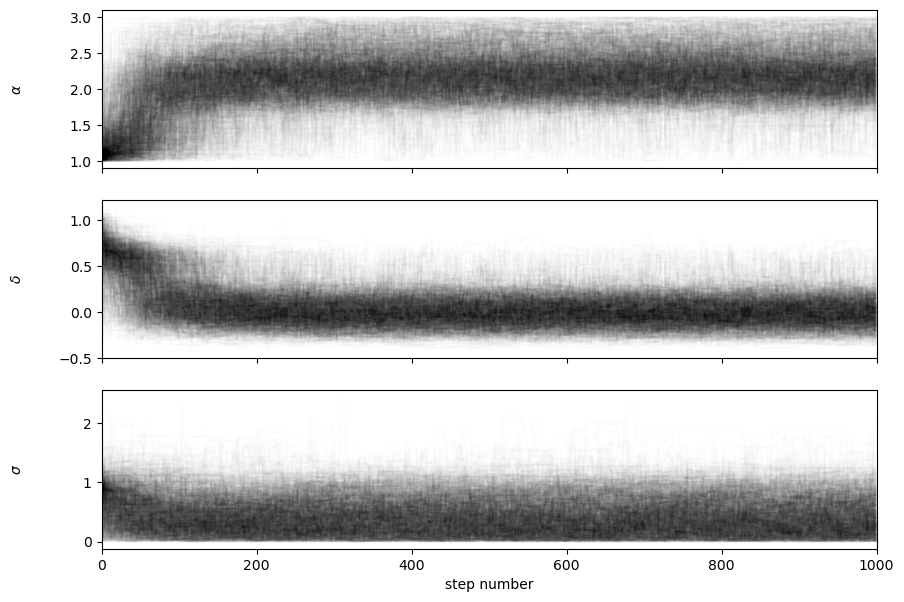

In [93]:
make_chain_plot(sampler)

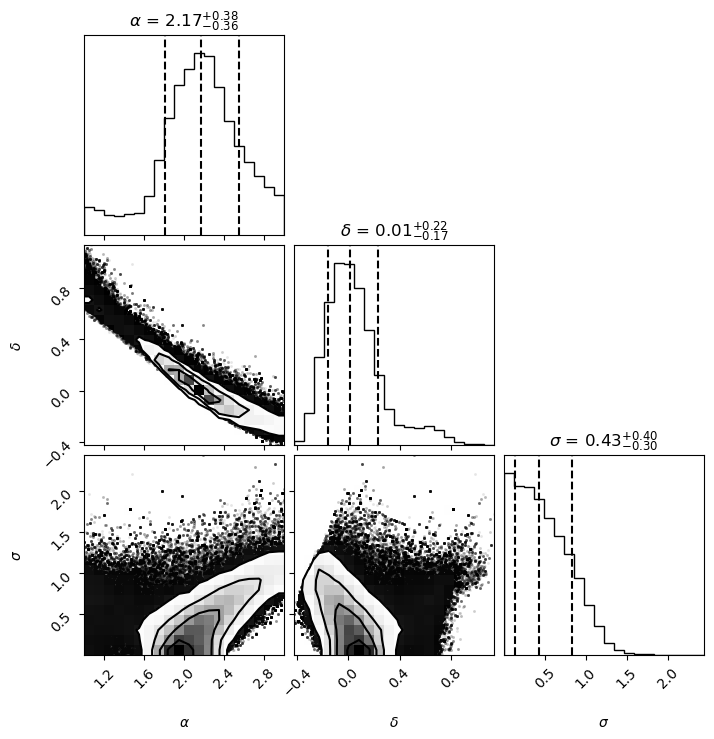

In [94]:
make_corner_plot(sampler)

In [95]:
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
# print("Running burn-in...")
# p0, _, _ = sampler.run_mcmc(p0, 300)
# sampler.reset()

# print("Running production...")
# pos, prob, state = sampler.run_mcmc(p0, niter)